In [1]:
# Dependencies

import numpy as np
import sys
import matplotlib.pyplot as plt 
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [20]:

## Parameters
betavec = [0,0.05,0.5,2]

res = 128;  # resolution
L = 10.;    # width
dx = L/res # grid spacing
dy = dx
xx = np.arange(-res/2.,res/2.)*dx
yy = np.copy(xx)
x,y = np.meshgrid(xx,yy)

dt = 1./32 # timestep
dtr = 1/dt # reciprical timestep
tmax = 100.
nt = np.int(tmax/dt)

savefreq = 64
nsave = np.int(tmax/dt/savefreq)

# INITIAL PV DISTRIBUTION
q0 = np.exp(-((x-10*(np.random.rand()-0.5))**2+(y-8*(np.random.rand()-0.5))**2)**4) - np.exp(-((x-10*(np.random.rand()-0.5))**2+(y-10*(np.random.rand()-0.5))**2)**4)

def evolve(q0):
    # output
    f1 = 0;
    k0 = 2*np.pi/L  # smallest wavenumber that fits in domain
    kk = np.concatenate((np.arange(0,res/2.+1),np.arange(-res/2.+1,0)))*k0
    ll = np.concatenate((np.arange(0,res/2.+1),np.arange(-res/2.+1,0)))*k0
    k,l = np.meshgrid(kk,ll)# spectral grid
    wv2 = k**2+l**2
    wv2r = -1./(wv2+f1) # Negative reciprical; Why do we even need f1 if its just zero?
    wv2r[0,0] = 0 # overwride INFs

    ### Glenn has some stuff that switches resolution here
    cphi = 0.65*np.pi # Default large-scale cutoff

    wvx = np.sqrt((k*dx)**2+(l*dy)**2) # wavenumber magnitude

    # Filter is 0 for scales larger than cphi; 1 for smaller scales
    filtr = np.exp(-18*(wvx-cphi)**7)*(wvx>cphi)+(wvx<=cphi) # Some kind of filter??? What does it do?
    filtr[np.isnan(filtr)] = 1.

    kmax2=((res/2.-1)*k0)**2 # ???
    trunc=(wv2<kmax2) # Truncate to select small wavenumbers (large scales)

    t = 0; # Running time
    tc = 0; # Timestep counter
    ts = 0; # Save counter

    qh1 = np.fft.fft2(q0) # FT of vorticity
    dqh1dt_p = 0 # Placeholder for PV at previous timestep
    
    # What are these timesteps?
    dt0=dt;
    dt1=0;

    while t<tmax:
        q1 = np.real(np.fft.ifft2(qh1*trunc)) # real part of inverse FT, ignoring smallest scales
        
        if (np.sum(np.isnan(q0[:])))>0:
            break
        ph1 = invert(qh1,wv2r) # spectral PV inversion
        u1,v1 = caluv(ph1,k,l,trunc) # Calculate velocities

        dqh1dt=-advect(q1,u1,v1,k,l)-beta*1j*k*ph1 # spectral PV tendency

        if (tc%savefreq)==0:
            usave[:,:,ts,b]=np.real(u1)
            vsave[:,:,ts,b]=np.real(v1)
            qsave[:,:,ts,b]=np.real(np.fft.ifft2(qh1*trunc))
            ts = ts+1

        qh1=filtr*(qh1+dt0*dqh1dt+dt1*dqh1dt_p)

        dqh1dt_p = dqh1dt
        
        if tc==0:
            dt0=1.5*dt
            dt1=-0.5*dt
        tc = tc+1
        t  = tc*dt

    q1 = np.real(np.fft.ifft2(qh1*trunc));
    q = q1;
    return
    
def caluv(ph1,k,l,trunc):
    u1 = -np.real(np.fft.ifft2(1j*l*ph1*trunc))
    v1 = +np.real(np.fft.ifft2(1j*k*ph1*trunc))
    return u1,v1
    
def advect(q1,u1,v1,k,l):
    # Return spectral advective flux
    return 1j*(k*np.fft.fft2(u1*q1)+l*np.fft.fft2(v1*q1))
    
def invert(qh1,wv2r):
    return qh1*wv2r    

qsave = np.zeros((res,res,nsave,len(betavec)))
usave = np.zeros((res,res,nsave,len(betavec)))
vsave = np.zeros((res,res,nsave,len(betavec)))
for b in range(len(betavec)):
    beta = betavec[b]
    evolve(q0)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


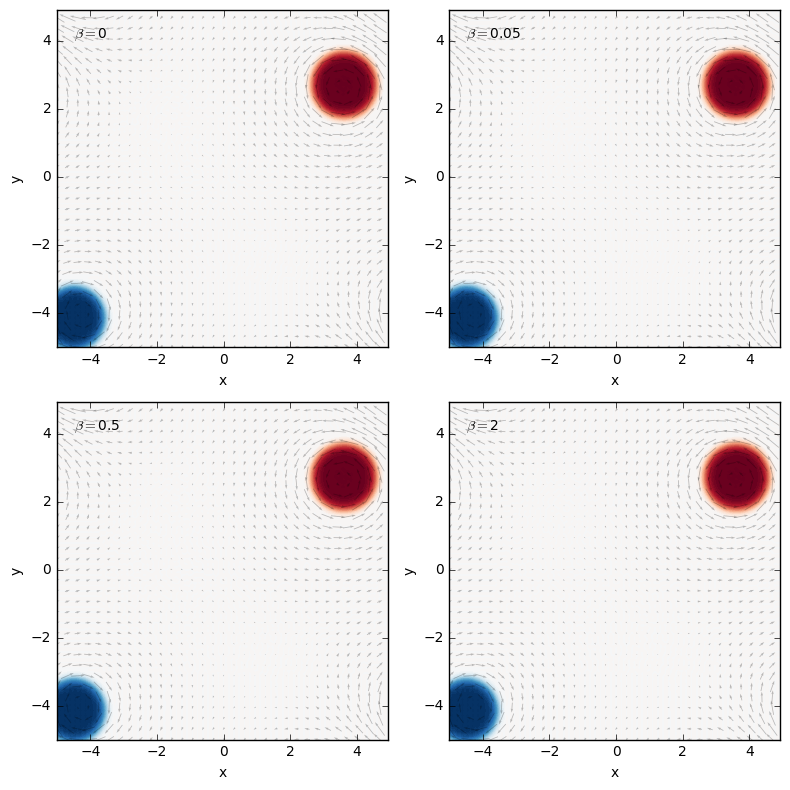

In [21]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
dc = 0.025

pvcontour = np.empty((2,2), dtype=object)
Q = np.empty((2,2), dtype=object)
for j in range(2):
    for k in range(2):
        ii=j*2+k
        pvcontour[j,k] = axes[j][k].contourf(x, y, qsave[:,:,0,ii],
                                levels=np.arange(-1.,1.+dc,dc),
                                cmap=plt.get_cmap("RdBu_r"), extend="both");
        Q[j,k] = axes[j][k].quiver(x[::res/32,::res/32], y[::res/32,::res/32],usave[::res/32,::res/32,0,ii],vsave[::res/32,::res/32,0,ii], pivot='mid',alpha = 0.25);
        axes[j][k].set_xlim(-L/2, L/2-dx)
        axes[j][k].set_ylim(-L/2, L/2-dy)
        axes[j][k].set_xlabel("x")
        axes[j][k].set_ylabel("y")
        axes[j][k].annotate(r"$\beta = $"+np.str(betavec[ii]),xy=(-4.5,4.1),fontsize=10)

plt.tight_layout()

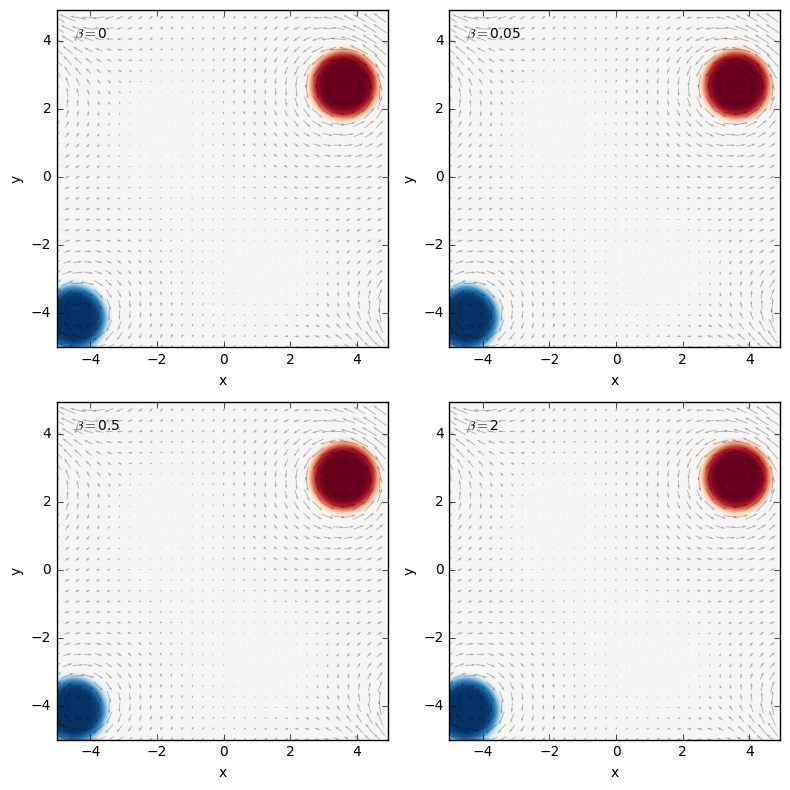

In [22]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
dc = 0.025

pvcontour = np.empty((2,2), dtype=object)
Q = np.empty((2,2), dtype=object)
for j in range(2):
    for k in range(2):
        ii=j*2+k
        pvcontour[j,k] = axes[j][k].contourf(x, y, qsave[:,:,0,ii],
                                levels=np.arange(-1.,1.+dc,dc),
                                cmap=plt.get_cmap("RdBu_r"), extend="both");
        Q[j,k] = axes[j][k].quiver(x[::res/32,::res/32], y[::res/32,::res/32],usave[::res/32,::res/32,0,ii],vsave[::res/32,::res/32,0,ii], pivot='mid',alpha = 0.25);
        axes[j][k].set_xlim(-L/2, L/2-dx)
        axes[j][k].set_ylim(-L/2, L/2-dy)
        axes[j][k].set_xlabel("x")
        axes[j][k].set_ylabel("y")
        axes[j][k].annotate(r"$\beta = $"+np.str(betavec[ii]),xy=(-4.5,4.1),fontsize=10)

plt.tight_layout()

# animation function. This is called sequentially
def animate(i):
    for j in range(2):
        for k in range(2):
            ii = j*2+k
            global pvcontour, Q
            for c in pvcontour[j,k].collections:
                c.remove()
            Q[j,k].remove()

            pvcontour[j,k] = axes[j][k].contourf(x, y, qsave[:,:,i,ii],
                                    levels=np.arange(-1.0,1.0+dc,dc),
                                    cmap=plt.get_cmap("RdBu_r"),extend="both");
            Q[j,k] = axes[j][k].quiver(x[::res/32,::res/32], y[::res/32,::res/32],usave[::res/32,::res/32,i,ii],vsave[::res/32,::res/32,i,ii],
                            pivot='mid', alpha=0.3);
    return (Q,pvcontour)

anim = animation.FuncAnimation(fig, animate, frames=nsave, interval=100, blit=False);

anim